In [67]:
import open3d as o3d
import cv2
import sys
import numpy as np
import argparse
import math
import os
from pathlib import Path
import sklearn.cluster as cluster
from sklearn import metrics
from matplotlib import pyplot as plt

# sub_cnt, bin_cnt = '2', '01'
# dir_path = '/home/ghosnp/dataset/cadc/data/000'+sub_cnt+'/labeled/lidar_points/data'
# file_name = '00000000'+bin_cnt+'.bin'

# # dir_path = '/home/ghosnp/project/fix_space/origin/carla_dataset_tools/raw_data/record_2023_1024_1907/vehicle.tesla.model3.master/test/velodyne'
# # file_name = '000002.bin'

# # dir_path = '/home/ghosnp/project/fix_space/origin/carla_dataset_tools/raw_data/record_2023_1019_2027/vehicle.tesla.model3.master/velodyne_CVL_beta_0.013/'
# # file_name = '0000445520.bin'

# pcd_path = os.path.join(dir_path, file_name)
# idx = '017579'
# pcd_path = '/home/newDisk/tool/carla_dataset_tool/dataset/training/velodyne/'+idx+'.bin'
pcd_path = '/home/newDisk/cadcd/rain_01.bin'
pre_point = np.fromfile(str(pcd_path), dtype=np.dtype([
                                    ('x', np.float32),
                                    ('y', np.float32),
                                    ('z', np.float32),
                                    ('intensity', np.float32),
                                ]) ,count=-1)

pcd = np.array([list(elem) for elem in pre_point])
#########################################################
radius = 18
depth = -0.2
loop = 3

select_point = pcd[np.sqrt(pcd[:,0]**2 + pcd[:,1]**2) < radius]
select_point = select_point[select_point[:,2] > depth]

# make the selected point into a polar coordinate
theta = np.arctan2(select_point[:,1], select_point[:,0])
r = np.sqrt(select_point[:,0]**2 + select_point[:,1]**2)
# theta to degree
theta = theta*180/math.pi

In [68]:
DB = cluster.DBSCAN(eps=1.5, min_samples=15)

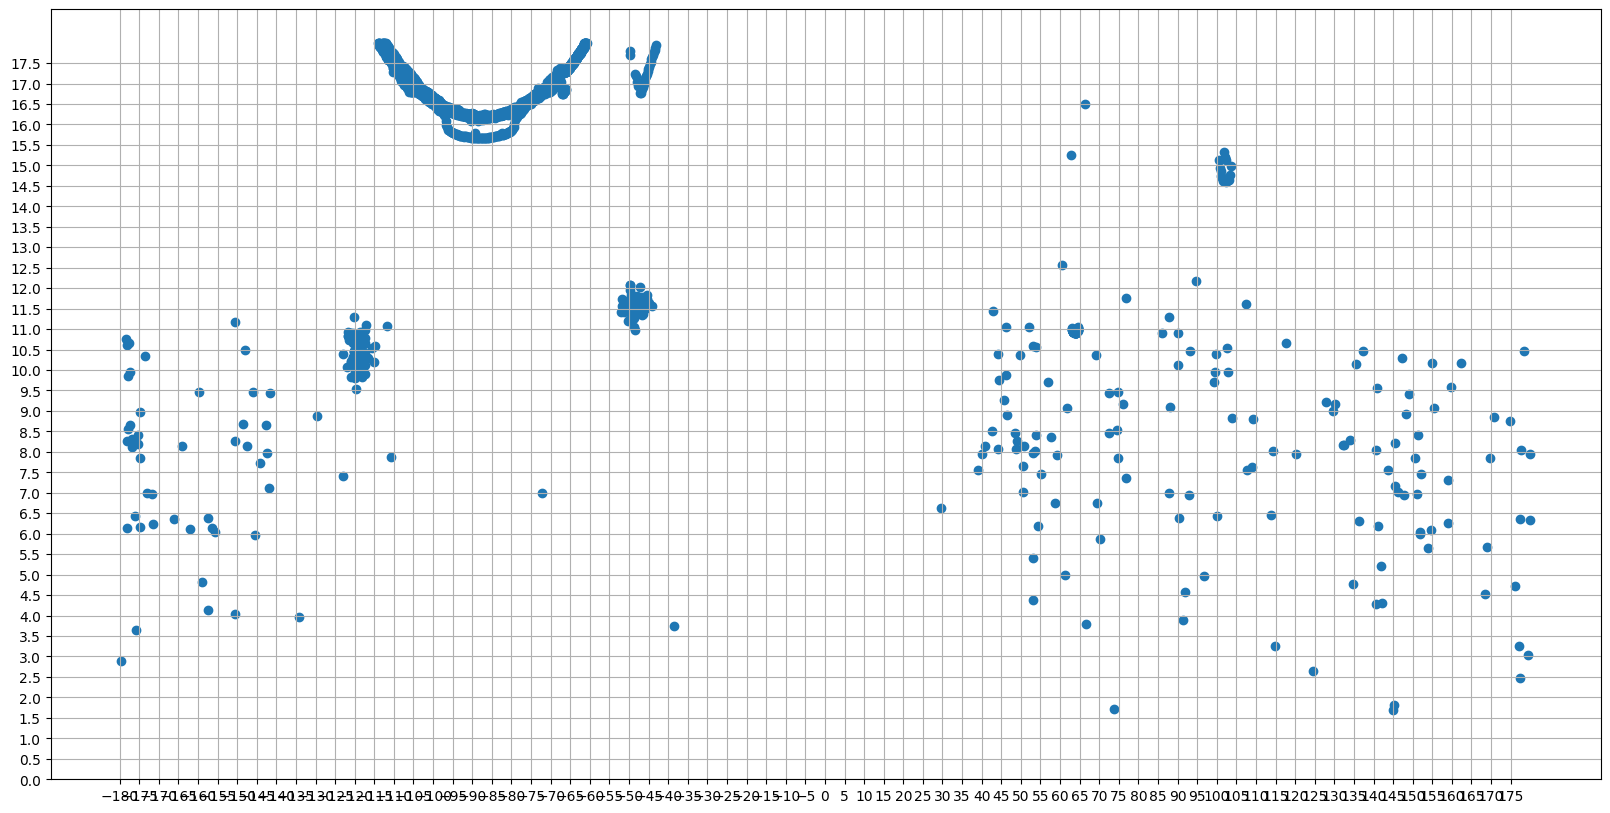

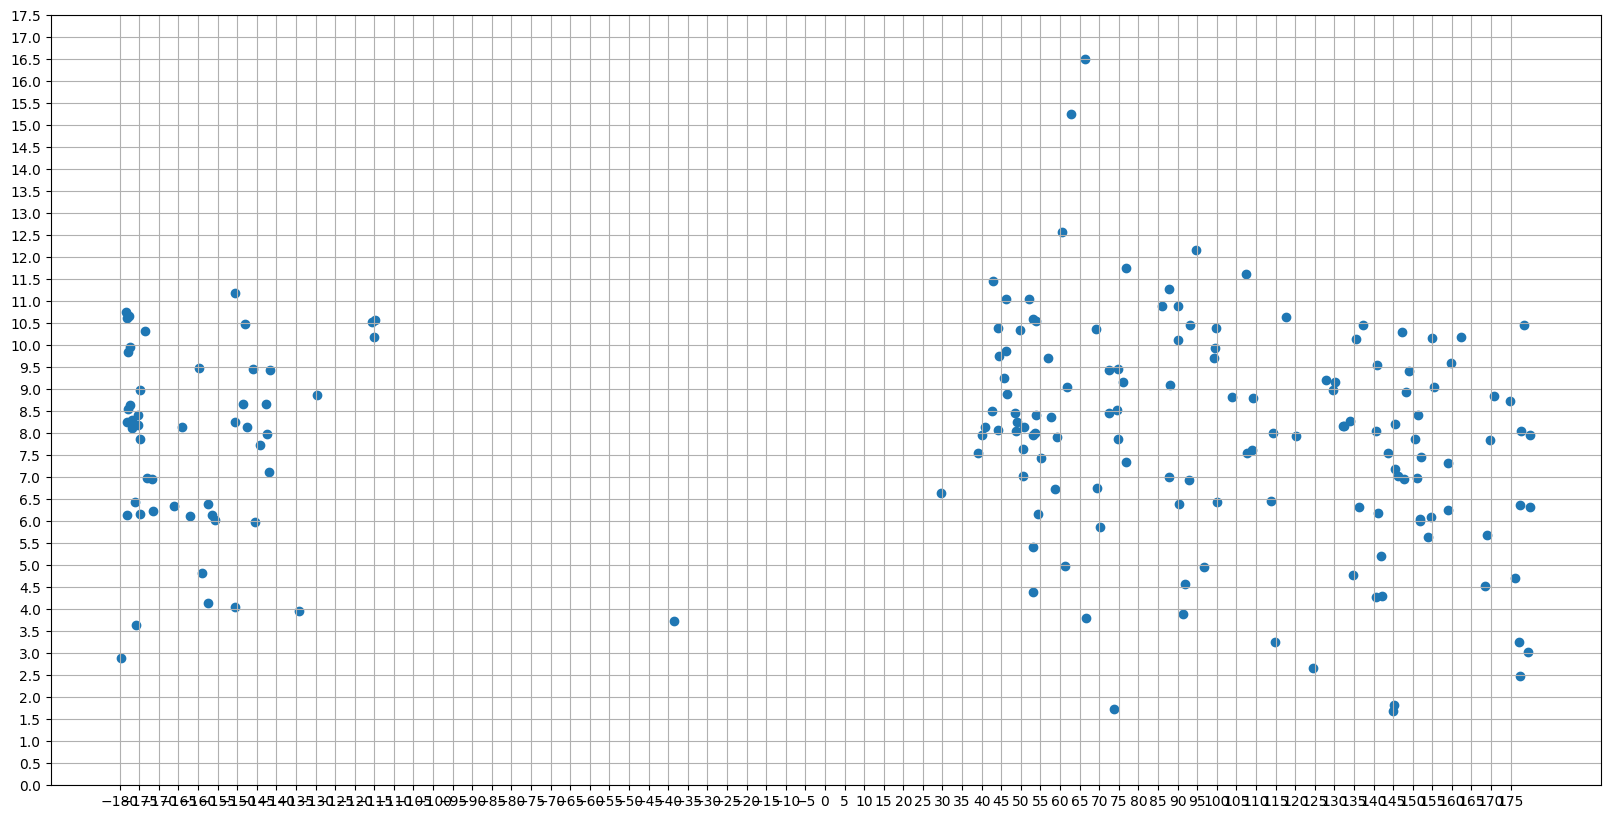

In [69]:
RADUIS = 18
DEPTH = -0.2
RANGE = 6
K = 0.2
# select probable points
select_point = pcd[np.sqrt(pcd[:,0]**2 + pcd[:,1]**2) < RADUIS]
select_point = select_point[select_point[:,2] > DEPTH]
theta = np.arctan2(select_point[:,1], select_point[:,0])
r = np.sqrt(select_point[:,0]**2 + select_point[:,1]**2)
theta = theta*180/math.pi
select_point_polar = np.array([theta, r]).T

plt.figure(figsize=(20,10))
plt.scatter(select_point_polar[:,0], select_point_polar[:,1])
plt.xticks(np.arange(-180, 180, 5))
plt.yticks(np.arange(0, radius, 0.5))
plt.grid()
plt.show()

for _ in range(loop):
    if len(select_point_polar) == 0:
        select_point_polar = last_select_point_polar
        break
    DB.fit(select_point_polar[:,0:2])
    cls_labels = DB.labels_
    n_clusters_ = len(set(cls_labels)) - (1 if -1 in cls_labels else 0)
    label_point = {i: select_point_polar[cls_labels==i] for i in range(n_clusters_)}
    label_range = {i: [np.min(label_point[i][:,0]), np.max(label_point[i][:,0])] for i in range(n_clusters_)}
    label_range = sorted(label_range.items(), key=lambda x:x[1][0])

    # check if the cluster is a obstacle, use near points
    near_points = {-1:0}
    thetas,rs = select_point_polar[:,0], select_point_polar[:,1]
    for [k,v] in label_range:
        mask = np.logical_and(thetas>=v[0], thetas<=v[1])
        near_points[k] = np.sum(rs[mask]<RANGE)
        cls_labels[mask] = k
    near_points[-1] = len(select_point_polar) - sum(near_points.values())

    if len(near_points) == 1:
        break

    label_rho = {k: v/(label_range[k][1][1]-label_range[k][1][0]) for k,v in near_points.items()}
    label_length = {k: label_range[k][1][1]-label_range[k][1][0] for k in label_rho.keys()}
    max_item = max(label_length.items(), key=lambda x:x[1])
    origin_length = 360 - sum(label_length.values())
    if origin_length < max_item[1]:
        origin_length = max_item[1]
        label_rho.pop(max_item[0])
        label_length.pop(max_item[0])
        near_points[-1] = near_points[max_item[0]]

    base_rho = K * near_points[-1]/origin_length
    drop_key = [k for k, v in label_rho.items() if v < base_rho]

    # drop the points in the obstacle cluster
    indice = [i for i in range(select_point_polar.shape[0]) if cls_labels[i] not in drop_key]
    last_select_point_polar = select_point_polar
    select_point_polar = select_point_polar[indice]

DB.fit(select_point_polar)
labels = DB.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
label_count = {}
label_point = {}
for i in range(n_clusters_):
    label_count[i] = np.sum(labels==i)
    label_point[i] = select_point_polar[labels==i]
plt.figure(figsize=(20,10))
plt.scatter(select_point_polar[:,0], select_point_polar[:,1])
plt.xticks(np.arange(-180, 180, 5))
plt.yticks(np.arange(0, radius, 0.5))
plt.grid()
plt.show()

In [70]:
label_range = {i: [np.min(label_point[i][:,0]), np.max(label_point[i][:,0])] for i in range(n_clusters_)}
length = sum([v[1]-v[0] for k,v in label_range.items()]) if len(label_range) > 0 else 360
alpha = select_point_polar.shape[0]/length

cal_pcd = pcd[pcd[:,3]!=0]
beta_all = (1-np.log(cal_pcd[:,3])) / np.sqrt(cal_pcd[:,0]**2+cal_pcd[:,1]**2+cal_pcd[:, 2]**2)
beta = np.mean(beta_all)

print('length: ', length)
print('alpha: ', alpha)
print('beta: ', beta)

length:  360
alpha:  0.5138888888888888
beta:  0.24380718


Text(0.5, 0.98, 'valid length=281.5873565673828')

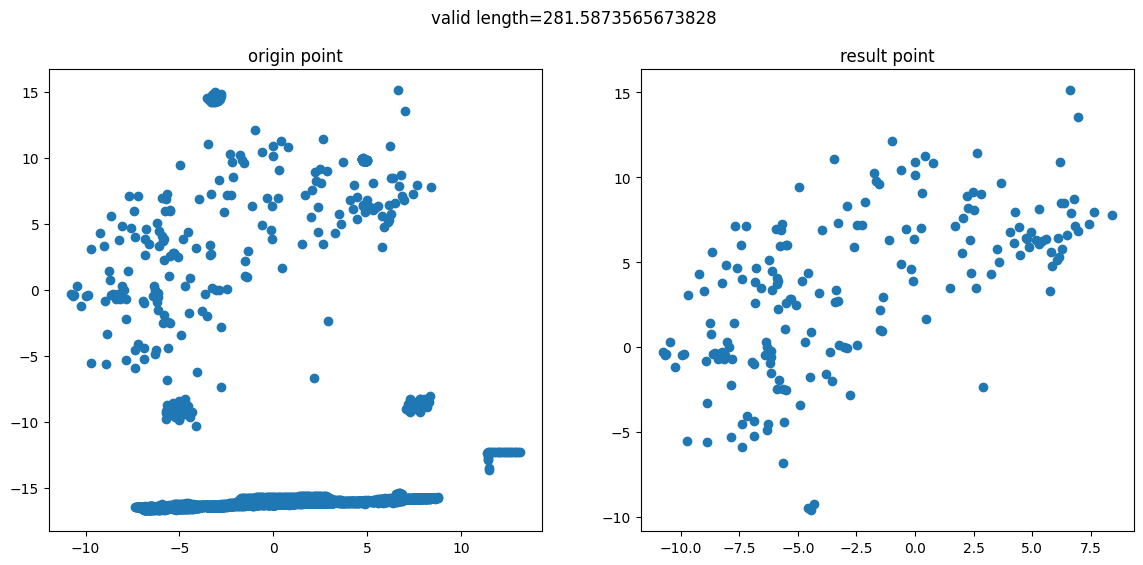

In [71]:
# 将result_point_polar转换为result_point
result_point = []
for i in range(select_point_polar.shape[0]):
    theta = select_point_polar[i,0]
    r = select_point_polar[i,1]
    x = r*math.cos(theta*math.pi/180)
    y = r*math.sin(theta*math.pi/180)
    result_point.append([x, y, 0])
result_point = np.array(result_point)

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(14, 6))
ax1.scatter(select_point[:,0], select_point[:,1])
ax1.set_title('origin point')
ax2.scatter(result_point[:,0], result_point[:,1])
ax2.set_title('result point')
# set figure title
fig.suptitle('valid length='+str(origin_length))